# Appendix (for the Lab) - From LogReg to a Feedforward Neural Network in Pytorch

# Neural network Learning

### Lets have a look at a simpler example - First generate some data


In [31]:
import pandas as pd
import numpy as np

num_observations = 1000

x_neg = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x_pos = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x_neg, x_pos)).astype(np.float32)
simulated_labels = np.array(np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))).astype(int)

data = pd.DataFrame({'x1': np.concatenate([x_neg[:,0],x_pos[:,0]]),
                     'x2': np.concatenate([x_neg[:,1],x_pos[:,1]]),
                     'label': simulated_labels})

data.head()

,x1,x2,label
0,-1.081637,-0.634803,0
1,0.939852,0.862057,0
2,-1.206902,-0.287912,0
3,0.620225,0.324054,0
4,0.136594,0.852036,0


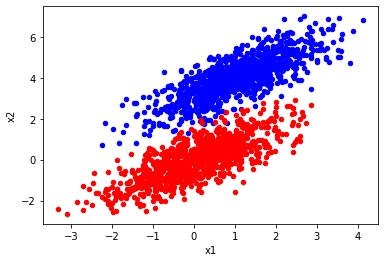

In [32]:
# plot the data
fig, ax = plt.subplots()

data.query('label == 1').plot(kind='scatter', x='x1', y='x2', ax=ax, color='b')
data.query('label == 0').plot(kind='scatter', x='x1', y='x2', ax=ax, color='r');

In [33]:
## plot utility functions from AJ and DH
def get_y(x, w1, w2, bias):
    '''
    compute y value for specific x, given the weights and bias
    (helper function for decision boundary)
    '''
    return (((-1 * x * w1) - bias) / w2)


def plot_decision_boundary(model, ax, alpha=0.1, color='black', thickness=1):
    '''
    plot the decision boundary
    '''
    bias, w1, w2 = model
    x_min = -5
    x_max = 5
    ax.plot([x_min, x_max], 
            [get_y(x_min, w1, w2, bias), get_y(x_max, w1, w2, bias)], 
            'k-', alpha=alpha, c=color, lw=thickness)

### How to Find the Optimum?

In practice one of the following:
* implement both optimisation and gradient calculation
* use off-the-shelf gradient descent library, provide the gradients (Example: [factorie](http://factorie.cs.umass.edu/), [scipy](https://www.scipy.org/))
* You have a back-propagation framework (such as Pytorch, Keras, Theano, DyNet, Tensorflow) 


## Logistic Regression in Pytorch


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(simulated_separableish_features, simulated_labels, test_size=0.2)
len(X_train), len(X_test)

(1600, 400)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a logistic Regression model in Pytorch
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        return self.sigmoid(out)

Training LogReg model
loss epoch 0: 0.5595623463543598 train accuracy: 0.655
loss epoch 10: 0.15720261821850726 train accuracy: 0.9725
loss epoch 20: 0.09961681993689125 train accuracy: 0.98625
loss epoch 30: 0.07666593815102715 train accuracy: 0.990625
loss epoch 40: 0.06410376931587962 train accuracy: 0.991875
tensor([[-1.2575],
        [ 2.3391]]) tensor([-3.5495])
Finished Training


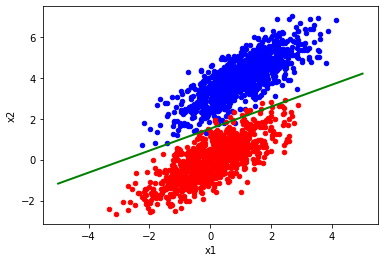

In [36]:
## train the logistic regression model in Pytorch
import torch.optim as optim

## define the input and model
input_dim=2
output_dim=1

logReg = LogisticRegression(input_dim, output_dim)

## define loss and train model
loss_function = nn.BCELoss() # binary cross entropy loss
optimizer = optim.SGD(logReg.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_train = len(X_train)

print('Training LogReg model')

for epoch in range(50):  # loop over the dataset for several epochs

    running_loss = 0.0
    running_acc = 0.0
    
    for j, (x_train_input, y_label) in enumerate(zip(X_train, y_train)):
        # convert to torch tensors
        x = torch.from_numpy(x_train_input).float().to(device)
        y = torch.tensor([y_label], dtype=torch.float32).to(device)
       
        # forward pass and loss calculation
        y_hat = logReg(x)
        loss = loss_function(y_hat, y)
        acc = torch.eq(y_hat.round(), y).float().mean() # accuracy (trick to convert boolean)
        
        #  zero the parameter gradients before the update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += acc.item()
    if epoch % 10 == 0:
        print("loss epoch {}: {} train accuracy: {}".format(epoch, running_loss/num_train, running_acc/num_train))
    running_loss = 0.0
    running_acc = 0.0

W = logReg.state_dict()['linear.weight'].t()
b = logReg.state_dict()['linear.bias'].t()
print(W,b)
print('Finished Training')
# plot the data and decision boundary
fig, ax = plt.subplots()

weights=[b,W[0],W[1]]
data.query('label == 1').plot(kind='scatter', x='x1', y='x2', ax=ax, color='b')
data.query('label == 0').plot(kind='scatter', x='x1', y='x2', ax=ax, color='r');
plot_decision_boundary(weights, alpha=1.0, color='green', thickness=2, ax=ax)



## A Feedforward Neural Network (FFNN) in Pytorch


In [37]:
# Feedforward neural network in Pytorch
import torch.nn as nn
import torch.nn.functional as F

class FFNeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FFNeuralNet, self).__init__()
        self.hidden = nn.Linear(input_dim, 15)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(15, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #return torch.sigmoid(self.output_layer(torch.relu(self.hidden(x))))
        hidden = self.hidden(x)
        relu = self.activation(hidden)
        out = self.output_layer(relu)
        return self.sigmoid(out)

In [38]:
import torch
import torch.optim as optim

def train_network(model, X_train, y_train):
    loss_function = nn.BCELoss() # binary cross entropy loss
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    losses = []
    accuracy = []
    num_train = len(X_train)

    for epoch in range(50):  # loop over the dataset for several epochs

        running_loss = 0.0
        running_acc = 0.0

        for j, (x_train_input, y_label) in enumerate(zip(X_train, y_train)):
            # convert to torch tensors
            x = torch.from_numpy(x_train_input).float()
            y = torch.tensor([y_label], dtype=torch.float32)

            # forward pass and loss calculation
            y_hat = model(x)
            loss = loss_function(y_hat, y)
            acc = torch.eq(y_hat.round(), y).float().mean() # accuracy (trick to convert boolean)

            #  zero the parameter gradients before the update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += acc.item()

        losses.append(running_loss/num_train)
        accuracy.append(running_acc/num_train)
        if epoch % 10 == 0:
            print("loss epoch {}: {} train accuracy: {}".format(epoch, running_loss/num_train, running_acc/num_train))
        running_loss = 0.0
        running_acc = 0.0

    print('Finished Training')
    #neural_net.state_dict()
    return losses, accuracy

In [39]:
## create instance of FFNN

input_dim=2
output_dim=1

neural_net = FFNeuralNet(input_dim, output_dim)
losses, accuracy = train_network(neural_net, X_train, y_train)

loss epoch 0: 0.5194920204370282 train accuracy: 0.766875
loss epoch 10: 0.07104942966005183 train accuracy: 0.986875
loss epoch 20: 0.03447008174711755 train accuracy: 0.993125
loss epoch 30: 0.025610196642093967 train accuracy: 0.991875
loss epoch 40: 0.021521408645365378 train accuracy: 0.993125
Finished Training


Text(0, 0.5, 'loss')

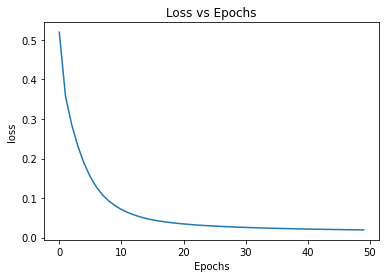

In [40]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

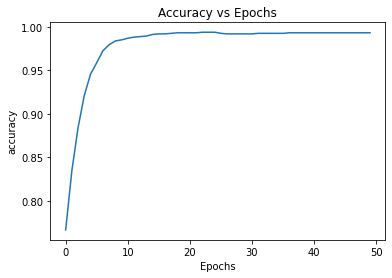

In [41]:
plt.plot(accuracy)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

## A non-linear example

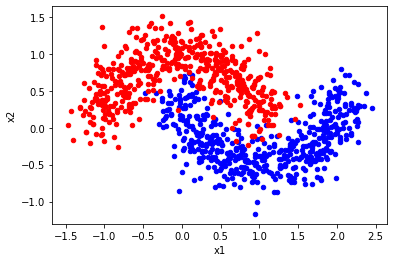

In [42]:
from sklearn.datasets import make_moons
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

def to_categorical(y, num_classes):
    """1-hot encodes a tensor"""
    return np.eye(num_classes, dtype='uint8')[y]

X, y = make_moons(n_samples=1000, noise=0.2)
data = pd.DataFrame({'label': y, "x1": X[:,0], "x2": X[:,1] })

fig, ax = plt.subplots()

data.query('label == 1').plot(kind='scatter', x='x1', y='x2', ax=ax, color='b')
data.query('label == 0').plot(kind='scatter', x='x1', y='x2', ax=ax, color='r');

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [44]:
logReg = LogisticRegression(input_dim, output_dim)
losses, accuracy = train_network(logReg, X_train, y_train)

loss epoch 0: 0.6042514875158668 train accuracy: 0.69875
loss epoch 10: 0.40388370989821853 train accuracy: 0.82
loss epoch 20: 0.35220247112913056 train accuracy: 0.84625
loss epoch 30: 0.32668091861880383 train accuracy: 0.8525
loss epoch 40: 0.3108467461622786 train accuracy: 0.8575
Finished Training


In [45]:
neural_net = FFNeuralNet(input_dim, output_dim)
losses, accuracy = train_network(neural_net, X_train, y_train)

loss epoch 0: 0.6657484888285399 train accuracy: 0.58875
loss epoch 10: 0.36976771752582865 train accuracy: 0.835
loss epoch 20: 0.29888346549880224 train accuracy: 0.86875
loss epoch 30: 0.2705167405452812 train accuracy: 0.87875
loss epoch 40: 0.25940367570321543 train accuracy: 0.88875
Finished Training


### References
* Yoav Goldberg's tutorial: [A Primer on Neural Network Models for Natural Language Processing](http://arxiv.org/abs/1510.00726)
* Jurafsky & Martin, [Speech and Language Processing (Third Edition)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf): Chapter 7 (up until 7.4)

Further references:
* Yoav Goldberg's book: [Neural Network Methods for Natural Language Processing](https://www.morganclaypoolpublishers.com/catalog_Orig/product_info.php?products_id=1056), McClaypool, 2017.
* More details in [Michael Nielsen's book chapter 1](http://neuralnetworksanddeeplearning.com/chap1.html)
* [Thumbs up? Sentiment Classification using Machine Learning
Techniques](http://www.cs.cornell.edu/home/llee/papers/sentiment.pdf), Bo Pang, Lillian Lee and Shivakumar Vaithyanathan, EMNLP 2002
* [Andrew Ng's course notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf)
* [Andrew Ng's video session on Logistic Regression](https://www.youtube.com/watch?v=LLx4diIP83I)
* [Nick Becker's post on Logistic Regression from scratch (uses batch stochastic descent)](https://github.com/beckernick/logistic_regression_from_scratch/blob/master/logistic_regression_scratch.ipynb)